# Explaining XGBoost model predictions with SHAP values
## Comparing the SHAP main effect for patients that attend a hospital, with the SHAP main effect for patients that do not attend a hospital

[Representing categorical features as one-hot encoded features in the model and keeping them separate for their SHAP value]

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03a_xgb_combined_shap_key_features.ipynb) we fit a single model to all of the data (no test set) and looked at SHAP values for the one-hot encded hosptial features. We looked at the SHAP values for patients that attend the hospital, and for those that do not (as we have seen that the hospital has a SHAP value when a patient attend another one, so there is a contribution to the prediction based on *not* attending a hospital). 

In this notebook we will look at the SHAP main effect values for patients that attend the hospital, and for those that do not. 

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we fit an XGBoost model to the SAMueL dataset, to predict whether a patient recieves thrombolysis from the values of eight features. We calculate the SHAP values of this fitted model and explore the SHAP main effect values for each of the one-hot encoded hospital features.

## Model and data

XGBoost model was trained on all of the data (no test set used). The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (0 = No, 1 = Yes)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Stroke team: Represented as one-hot encoded features

And one target feature:
* Thrombolysis: Did the patient recieve thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the SHAP values for the hospital one-hot encoded features

## Observations
* SHAP values for the one-hot encoded hospital features are very dependent on whether the instance attended the hospital or not
* SHAP values for the attended one-hot encoded hospital feature are largely one side of zero or the other. There are fewer instances in this population, but the range of SHAP values is wider.
* SHAP values for the not attended one-hot encoded hospitals are largely centred on zero. There are more instances in this population, but the range of SHAP values is narrower.
* 58% of the variability in hospital thrombolysis rate can be explained by the SHAP value for the one-hot encoded hospital feature (the median of those instances that attend the hospital).

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import os
import pickle

import math # to .floor and .ceil

# So can take deep copy
import copy

from os.path import exists
import json

#import scipy.stats

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_of_features_to_use = 8
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03b'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

In [7]:
## Get list of feature names

In [8]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [9]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [10]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [11]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

## Load XGBoost model

An XGBoost model was trained on the full dataset (rather than train/test splits used to assess accuracy) in notebook 03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb

In [12]:
# Load models
filename = (f'./saved_models/03a_{model_text}.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)
        
# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.874


## SHAP interaction values

A SHAP interaction value is returned for each pair of features (including with itself, which is known as the main effect), for each instance. The SHAP value for a feature is the sum of it's pair-wise feature interactions.


We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP interaction values from XGBoost model are log odds ratios.

### Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature)

Use these values to access the main effect for each of the one-hot encoded hospital features.

Either load from pickle (if file exists), or calculate.

In [13]:
%%time

# Get explainer from pickle

filename = f'./output/03a_{model_text}_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # ERROR CATCHER AS NEED TO RUN NOTEBOOK 3A FIRST
    print("Error")

filename = f'./output/{notebook}_{model_text}_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        shap_interaction = pickle.load(filehandler)
else:
    # Get SHAP interaction values
    shap_interaction = explainer.shap_interaction_values(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_interaction, filehandler)

CPU times: user 1.91 s, sys: 2.37 s, total: 4.27 s
Wall time: 2.35 s


SHAP interaction values have a matrix of values (per pair of features) per instance.\
In this case, each of the 88792 instances has a 139x139 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [14]:
shap_interaction.shape

(88792, 139, 139)

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [15]:
shap_interaction[0]

array([[ 6.9311428e-01,  3.5109535e-02, -5.6171417e-04, ...,
         2.1258509e-04, -6.8530644e-05, -8.5086795e-04],
       [ 3.5109580e-02,  3.4838551e-01,  4.9971551e-02, ...,
         0.0000000e+00, -1.5326077e-07,  1.3407553e-06],
       [-5.6150556e-04,  4.9971461e-02,  8.3505976e-01, ...,
        -1.4024938e-04,  1.5478528e-03,  3.5843346e-05],
       ...,
       [ 2.1257997e-04,  0.0000000e+00, -1.4033914e-04, ...,
         3.0400229e-03,  0.0000000e+00,  1.5953556e-06],
       [-6.8545341e-05, -1.4901161e-07,  1.5478432e-03, ...,
         0.0000000e+00, -4.5095785e-03,  0.0000000e+00],
       [-8.5088611e-04,  1.3411045e-06,  3.5852194e-05, ...,
         1.5952392e-06,  0.0000000e+00,  4.1305181e-03]], dtype=float32)

### Understand SHAP main effect for the one-hot encoded hospital features 

We've seen in notebook 3a that the categorical feature represented as a one-hot encoded feature have a SHAP value for each of the one-hot encoded features, and that the SHAP value (for the instances that attended the hospital) accounts for 58% of the variance in the hositals thrombolysis rate.

Here we will focus on understanding the SHAP main effect values for each hospital, their contribution when a patient attends the hospital, and the contribution when the patient does not attend the hospital.

#### Format the data 

Features are in the same order in shap_interaction as they are in the original dataset.

Use this fact to extract the SHAP main effect values for the one-hot encoded hospital features. Create a dataframe containing the SHAP main effect values: an instance per row, and a one-hot encoded hospital feature per column.

In [16]:
# Get list of hospital one hot encoded column titles
hospital_names_ohe = X.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column index for these hospital column titles
hospital_columns_index = [X.columns.get_loc(col) for col in hospital_names_ohe]

hosp_shap_main_effects = []
# Use this index list to access the hosptial shap values (as array) in the loop below
for i in range(shap_interaction.shape[0]):
    # Get the main effect value for each of the features
    main_effects = np.diagonal(shap_interaction[i])
    hosp_shap_main_effects.append(main_effects[hospital_columns_index])
    
# Put in dataframe with hospital as column title
df_hosp_shap_main_effects = pd.DataFrame(hosp_shap_main_effects, columns = hospital_names)

Also include four further columns:
1) the hospital that the instance attended
2) contribution from all of the one-hot encoded hospital features
3) contribution from just the hospital attended
4) contribution from not attending the rest

In [17]:
# Include Stroke team that each instance attended
df_hosp_shap_main_effects["Stroke team"] = X_combined["Stroke team"].values

# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_main_effects["all_stroke_teams"] = df_hosp_shap_main_effects.sum(axis=1)

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for 
#   the sum of the rest of the hospitals
shap_attended_hospital = []
shap_not_attend_these_hospitals = []

# For each patient
for index, row in df_hosp_shap_main_effects.iterrows():

    # Get stroke team attended
    stroke_team = row["Stroke team"]
    
    # Get SHAP value for the stroke team attended
    shap_attended_hospital.append(row[stroke_team])

    # Calculate sum of SHAP values for the stroke teams not attend 
    sum_rest = row["all_stroke_teams"] - row[stroke_team]
    shap_not_attend_these_hospitals.append(sum_rest)

# Store two new columns in dataframe
df_hosp_shap_main_effects["attended_stroke_team"] = shap_attended_hospital
df_hosp_shap_main_effects["not_attended_stroke_teams"] = shap_not_attend_these_hospitals
                   
# View preview
df_hosp_shap_main_effects.head()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.001201,-0.010994,0.003772,-0.000236,-0.000516,0.001511,0.002794,-0.004233,-0.000425,-0.002723,...,0.000311,0.000812,-0.001057,0.003040,-0.004510,0.004131,TXHRP7672C,-0.192045,-0.104753,-0.087292
1,0.001817,-0.008547,0.003398,-0.000177,-0.000785,0.001611,0.003012,-0.004515,-0.000503,-0.002588,...,0.000442,0.000734,-0.001323,0.002653,-0.003572,0.005024,SQGXB9559U,-0.660367,-0.574617,-0.085751
2,0.002611,-0.009957,0.003751,-0.000166,-0.000635,0.001732,0.003001,-0.003861,-0.001679,-0.002264,...,0.000306,0.000837,-0.001177,0.002934,-0.003586,0.004676,LFPMM4706C,-1.197422,-1.105975,-0.091447
3,0.001719,-0.010199,0.003087,-0.000096,-0.000516,0.001612,0.003012,-0.003859,-0.000528,-0.002537,...,0.000333,0.000734,-0.001044,0.003054,-0.003611,0.004465,MHMYL4920B,0.849224,0.919308,-0.070084
4,0.001600,-0.009127,0.003285,-0.000236,-0.000516,0.001542,0.002996,-0.003869,-0.000539,-0.002627,...,0.000311,0.000776,-0.001057,0.002845,-0.003145,0.004961,EQZZZ5658G,-0.105809,-0.028928,-0.076882


#### Boxplot (all hospitals together)

Boxplot to analyse the range of SHAP main effect values for the one-hot encoded hospital features. Show as two populations: the attended hosptial, the sum of the hospitals not attended

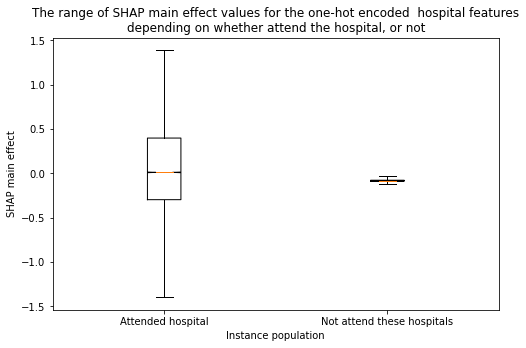

In [18]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.boxplot([shap_attended_hospital, shap_not_attend_these_hospitals],
            labels=["Attended hospital", "Not attend these hospitals"],
            whis=99999, notch=True);
title = ("The range of SHAP main effect values for the one-hot encoded "
         " hospital features\ndepending on whether attend the hospital, or not")
ax.set_title(title)
ax.set_xlabel("Instance population")
ax.set_ylabel("SHAP main effect");

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_hosp_shap_maineffect_attend_vs_notattend_boxplot.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Boxplot (individual hospitals)

Create a boxplot to show the range of SHAP values for each individual one-hot encoded hospital feature. 

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of median SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the median SHAP main effect value for each hosptial (for those instances that attended the hospital)

In [19]:
# Create list of SHAP main effect values (one per hospital) for those instances
#   that attend the hospital
attend_stroketeam_min = []
attend_stroketeam_q1 = []
attend_stroketeam_median = []
attend_stroketeam_q3 = []
attend_stroketeam_max = []
for h in hospital_names:
    mask = df_hosp_shap_main_effects['Stroke team'] == h
    data_stroke_team = df_hosp_shap_main_effects[h][mask]
    q1, q3 = np.percentile(data_stroke_team, [25,75])
    attend_stroketeam_min.append(data_stroke_team.min())
    attend_stroketeam_q1.append(q1)
    attend_stroketeam_median.append(data_stroke_team.median())
    attend_stroketeam_q3.append(q3)
    attend_stroketeam_max.append(data_stroke_team.max())
    
# Create dataframe with six columns (hospital and descriptive stats)
df_hosp_shap_main_stats = pd.DataFrame(hospital_names, columns=["hospital"])
df_hosp_shap_main_stats["shap_min"] = attend_stroketeam_min
df_hosp_shap_main_stats["shap_q1"] = attend_stroketeam_q1
df_hosp_shap_main_stats["shap_median"] = attend_stroketeam_median
df_hosp_shap_main_stats["shap_q3"] = attend_stroketeam_q3
df_hosp_shap_main_stats["shap_max"] = attend_stroketeam_max

# sort in descending SHAP main effect value order
df_hosp_shap_main_stats.sort_values("shap_median", ascending=False, inplace=True)                
df_hosp_shap_main_stats.head(5)

,hospital,shap_min,shap_q1,shap_median,shap_q3,shap_max
9,CNBGF2713O,0.961615,1.076589,1.130494,1.167219,1.355573
25,GKONI0110I,0.742977,0.982735,1.051632,1.134989,1.360788
32,HPWIF9956L,0.842229,0.982865,1.036947,1.084533,1.264853
109,VKKDD9172T,0.558505,0.959588,1.012563,1.077372,1.342864
65,NTPQZ0829K,0.767124,0.962494,1.003501,1.047912,1.253277


Add admission figures to xlabel in boxplot

Create dataframe with admissions and thrombolysis rate per stroke team (index)

In [20]:
# Get Stroke team name, the stroke team admission numbers, and list of SHAP values for each instance that attended teh stroke team
unique_stroketeams_list = list(set(X_combined["Stroke team"]))
admissions = [X[f'team_{s}'].sum() for s in unique_stroketeams_list]

df_stroketeam_ivt_adms = pd.DataFrame(unique_stroketeams_list, 
                                      columns=["Stroke team"])
df_stroketeam_ivt_adms["Admissions"] = admissions
df_stroketeam_ivt_adms.set_index("Stroke team", inplace=True)
df_stroketeam_ivt_adms.sort_values("Admissions", ascending=True, inplace=True)

# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]

# Join IVT rate with admissions per hosptial
df_stroketeam_ivt_adms = df_stroketeam_ivt_adms.join(hosp_ivt_rate)

df_stroketeam_ivt_adms

,Admissions,Thrombolysis
Stroke team,,
JXJYG0100P,120,0.233333
VVDIY0129H,130,0.192308
YEXCH8391J,149,0.228188
CNBGF2713O,152,0.480263
XPABC1435F,166,0.216867
...,...,...
JINXD0311F,1377,0.368192
AKCGO9726K,1428,0.369748
OFKDF3720W,1488,0.228495


Create data for boxplot. Using order of hospitals from the df_hosp_shap_value_stats dataframe.

In [21]:
# Go through this order of hospitals
hospital_order = df_hosp_shap_main_stats["hospital"]
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
attend_stroketeam_groups_ordered = []
not_attend_stroketeam_groups_ordered = []

# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:
    # Attend
    mask = df_hosp_shap_main_effects['Stroke team'] == h
    attend_stroketeam_groups_ordered.append(df_hosp_shap_main_effects[h][mask])
    # Not attend
    mask = df_hosp_shap_main_effects['Stroke team'] != h
    not_attend_stroketeam_groups_ordered.append(df_hosp_shap_main_effects[h][mask])
    # Label
    ivt_rate = int(df_stroketeam_ivt_adms['Thrombolysis'].loc[h] * 100)
    xlabel.append(f"{h} ({df_stroketeam_ivt_adms['Admissions'].loc[h]}, "
                  f"{ivt_rate}%)")

Plot the boxplot

Resource for using overall y min and max of both datasets on the 4 plots so have the same range
#https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists.

Shows the range of contributions to the prediction from this hospital when patients 1) do [black], and 2) do not [orange] attend this hosptial


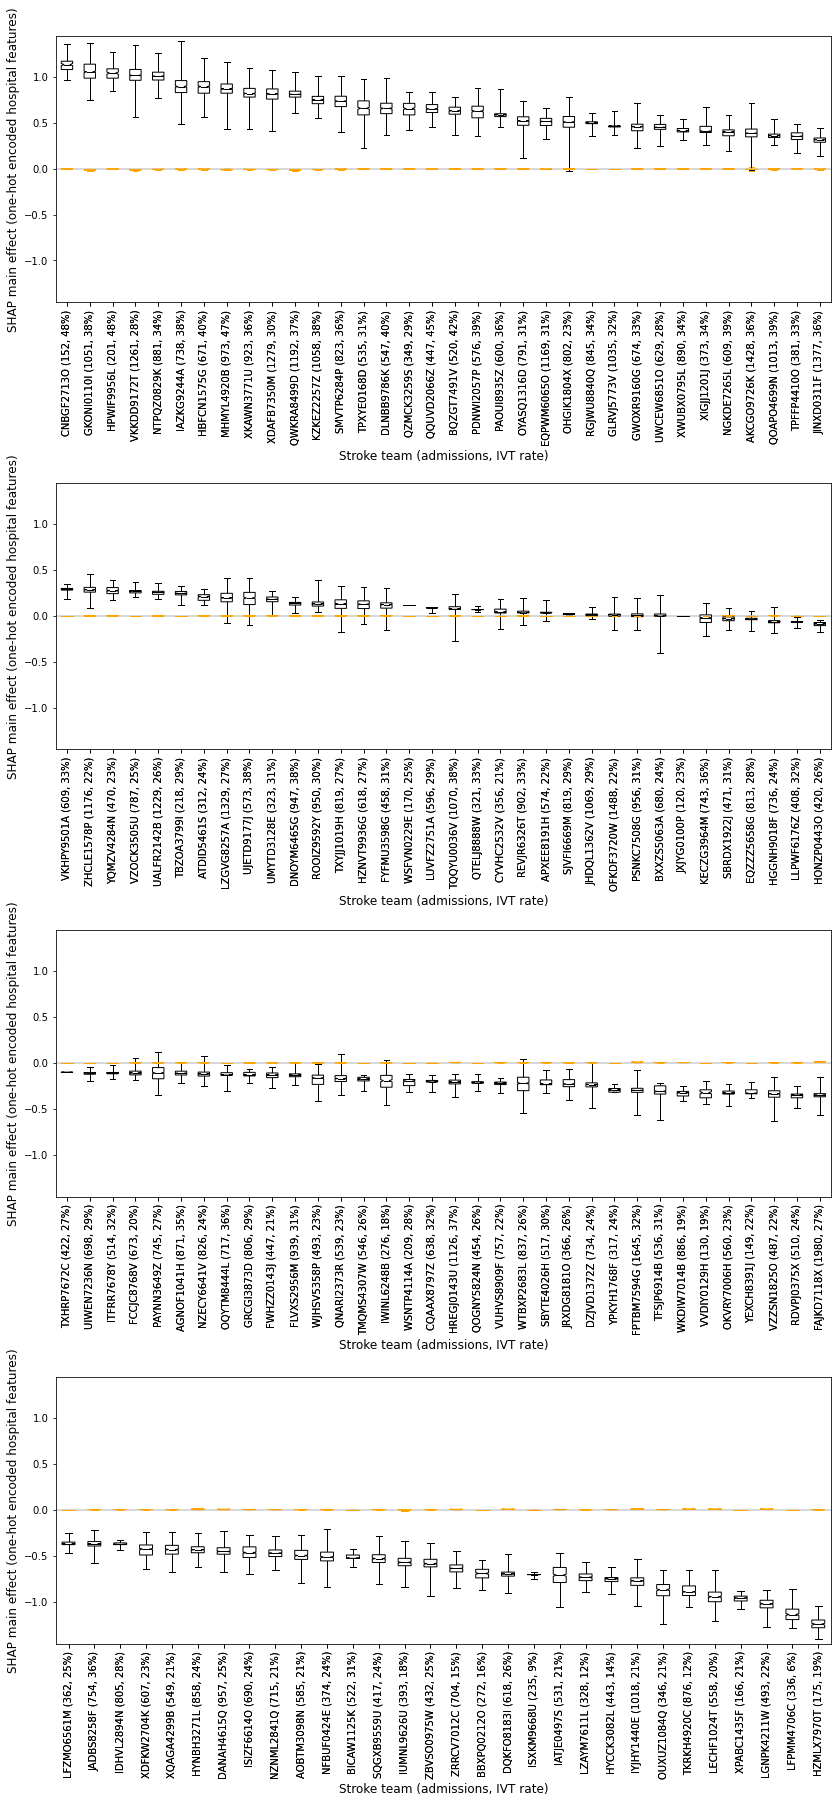

In [22]:
# Plot 34 hospitals on each figure to aid readability
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this "
      "hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin1 = min(min(attend_stroketeam_groups_ordered, key=min))
ymin2 = min(min(not_attend_stroketeam_groups_ordered, key=min))
ymax1 = max(max(attend_stroketeam_groups_ordered, key=max))
ymax2 = max(max(not_attend_stroketeam_groups_ordered, key=max))
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin1
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,25))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)

    # "The contribution from this hospital when patients do not attend this hosptial"
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    ax.boxplot(not_attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],#df_hosp["hospital"][st:ed],
               whis=99999,patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               medianprops=dict(color=c2))
       
    # The contribution from this hospital when patients do attend this hosptial"
    c1 = "black"
    c2 = "black"
    c3 = "white"
    ax.boxplot(attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],#df_hosp["hospital"][st:ed],
               whis=99999,patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               medianprops=dict(color=c2))

    plt.ylabel('SHAP main effect (one-hot encoded hospital features)',size=12)
    plt.xlabel('Stroke team (admissions, IVT rate)',size=12)
    plt.ylim(ymin, ymax)
    plt.xticks(rotation=90)
    # Add line at Shap = 0
    ax.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)
plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}'
            f'_individual_hosp_shap_maineffect_attend_vs_notattend_boxplot.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

Notice that when patients do not attend the hospital the range of the SHAP values are largely centred on zero.
When patients do attend hosptial, the range of SHAP values are largely one side of zero or the other (only a minority of hospitals have their interquartile range spanning zero).

In [23]:
iqr_below_zero = df_hosp_shap_main_stats["shap_q3"] < 0
iqr_spans_zero = df_hosp_shap_main_stats["shap_q1"] * df_hosp_shap_main_stats["shap_q3"]
iqr_above_zero = df_hosp_shap_main_stats["shap_q1"] > 0
iqr_is_zero1 = df_hosp_shap_main_stats["shap_q1"] == 0
iqr_is_zero2 = df_hosp_shap_main_stats["shap_q3"] == 0
iqr_is_zero = iqr_is_zero1 * iqr_is_zero2

print (f"There are {iqr_below_zero.sum()} hospitals whose interquartile range is below zero")
print (f"There are {iqr_spans_zero.lt(0).sum()} hospitals whose interquartile range spans zero")
print (f"There are {iqr_above_zero.sum()} hospitals whose interquartile range is above zero")
print (f"There are {iqr_is_zero.sum()} hospitals whose interquartile range is zero")

There are 69 hospitals whose interquartile range is below zero
There are 4 hospitals whose interquartile range spans zero
There are 58 hospitals whose interquartile range is above zero
There are 1 hospitals whose interquartile range is zero


How does the SHAP value for the one-hot encoded hospital features compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and SHAP value (for those patients that attend the hospital).

In [24]:
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]
df_hosp_plot = df_hosp_shap_main_stats[["shap_median","hospital"]].copy(deep=True)
df_hosp_plot.set_index("hospital", inplace=True)
df_hosp_plot = df_hosp_plot.join(hosp_ivt_rate)
df_hosp_plot

,shap_median,Thrombolysis
hospital,,
CNBGF2713O,1.130494,0.480263
GKONI0110I,1.051632,0.389153
HPWIF9956L,1.036947,0.487562
VKKDD9172T,1.012563,0.284695
NTPQZ0829K,1.003501,0.349603
...,...,...
LECHF1024T,-0.945496,0.204301
XPABC1435F,-0.958807,0.216867
LGNPK4211W,-1.021869,0.227181


Plot SHAP value for one-hot encoded hospital feature (median for those instances that attend the hospital) vs hospital IVT rate

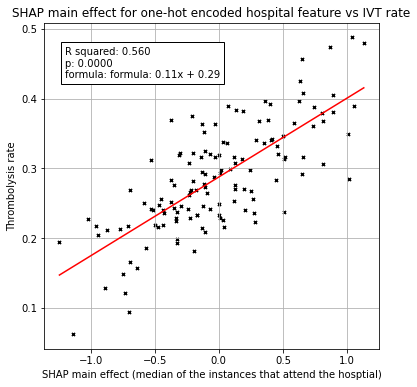

In [48]:
# Setup data for chart
x = df_hosp_plot['shap_median']
y = df_hosp_plot['Thrombolysis']

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(x, y, color='black', marker='x', s=10)
ax.plot (x, y_pred, color='red')
f = 'formula: ' + str("{:.2f}".format(slope)) + 'x + ' + str("{:.2f}".format(intercept))
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}\nformula: {f}'
ax.text(-1.2, 0.43, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax.set_xlabel("SHAP main effect (median of the instances that attend the hosptial)")
ax.set_ylabel('Thrombolysis rate')
ax.set_title("SHAP main effect for one-hot encoded hospital feature vs IVT rate")
plt.grid()

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_attended_hosp_shap_maineffect_vs_ivt_rate.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

### Observations
* SHAP main effect values for the one-hot encoded hospital features are very dependent on whether the instance attended the hospital or not
* SHAP main effect values for the attended one-hot encoded hospital feature are largely one side of zero or the other. There are fewer instances in this population, but the range of SHAP values is wider.
* SHAP main effect values for the not attended one-hot encoded hospitals are largely centred on zero. There are more instances in this population, but the range of SHAP values is narrower.
* 56% of the variability in hospital thrombolysis rate can be explained by the SHAP main effect value for the one-hot encoded hospital feature (the median of those instances that attend the hospital).

# Extra code.

There was a journey to analyse the data and arrive at the boxplot - that best visulaisation that we've yet found to summarise the data. Below are the other ways we looked at the data.

View descriptive stats

In [26]:
df_hosp_shap_main_effects.describe()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,XWUBX0795L,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
count,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,...,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000,88792.000000
mean,0.000243,-0.003130,0.000005,0.000032,0.000077,-0.000531,-0.000081,-0.000431,-0.000538,-0.000616,...,-0.000523,-0.000149,-0.000295,0.000258,0.000041,0.000153,-0.000448,-0.030271,0.052689,-0.082960
std,0.011947,0.050743,0.040876,0.003179,0.012266,0.038714,0.039420,0.048259,0.006135,0.046860,...,0.042400,0.013128,0.017791,0.019868,0.041189,0.032789,0.057144,0.493682,0.489084,0.008613
min,-0.223066,-0.024045,-0.793224,-0.057072,-0.001088,-0.876258,-0.626894,-0.005667,-0.407501,-0.003425,...,-0.006917,-0.387550,-0.320507,-0.001838,-0.940678,-0.006679,-0.848240,-1.497030,-1.400087,-0.120591
25%,0.001090,-0.010505,0.002911,-0.000220,-0.000783,0.001510,0.002828,-0.004401,-0.000700,-0.002655,...,-0.004965,0.000311,0.000734,-0.001323,0.002599,-0.004002,0.004354,-0.383786,-0.296970,-0.088588
50%,0.001515,-0.009361,0.003299,-0.000177,-0.000635,0.001590,0.002983,-0.004154,-0.000518,-0.002578,...,-0.004662,0.000409,0.000770,-0.001177,0.002849,-0.003640,0.004686,-0.075368,0.010999,-0.083155
75%,0.001718,-0.008349,0.003592,-0.000166,-0.000516,0.001686,0.003020,-0.003872,-0.000377,-0.002437,...,-0.004538,0.000433,0.000811,-0.001044,0.003064,-0.003193,0.004951,0.319416,0.398222,-0.077537
max,0.012115,0.707316,0.006298,0.172037,0.286433,0.002232,0.003442,0.782122,0.221268,1.355573,...,0.538676,0.000522,0.000877,0.383330,0.005151,0.448915,0.006341,1.330727,1.387742,-0.032971


Are there any hospitals that only have one value for all instances?
This indicates that the feature was not used to divide a node in any of the trees.

In [27]:
print("These hospitals have the same SHAP value for all patients")
for h in hospital_names:
    if df_hosp_shap_main_effects[h].nunique() == 1:
        print(f"{h} has SHAP value {df_hosp_shap_main_effects[h].unique()[0]} for all instances")

These hospitals have the same SHAP value for all patients
JXJYG0100P has SHAP value 0.0 for all instances


What's the range of number of unique values for each hospital for all patients?

The count of unique SHAP main effect values for each hospital


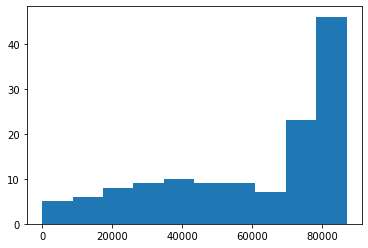

In [28]:
print ("The count of unique SHAP main effect values for each hospital")
n_unique_per_hosptial = [
            df_hosp_shap_main_effects[h].nunique() for h in hospital_names]                         
fig, axes = plt.subplots(1)
axes.hist(n_unique_per_hosptial);

Is there a relationship between number of unique SHAP main effect values, and hospital admission numnbers?

In [29]:
# Calculate the number of admissions per hospital
admissions = [X[h].sum() for h in hospital_names_ohe]

# Calculate number of unique SHAP values
n_unique_per_hosptial_all_instances = [
                df_hosp_shap_main_effects[h].nunique() for h in hospital_names]

# Calculate number of unique SHAP values for patients that attend
n_unique_per_hosptial_attend = []
n_unique_per_hosptial_not_attend = []
for h in hospital_names:
    mask = df_hosp_shap_main_effects["Stroke team"] == h
    n_unique_per_hosptial_attend.append(
                                df_hosp_shap_main_effects[h][mask].nunique())
    mask = np.logical_not(mask)
    n_unique_per_hosptial_not_attend.append(
                                df_hosp_shap_main_effects[h][mask].nunique())

# Store in dataframe
df_hospital_details = pd.DataFrame(admissions, columns=["admissions"])
df_hospital_details["number_of_unique_shap_values"] = (
                                            n_unique_per_hosptial_all_instances)
df_hospital_details["number_of_unique_shap_values_attend"] = (
                                            n_unique_per_hosptial_attend)
df_hospital_details["number_of_unique_shap_values_not_attend"] = (
                                            n_unique_per_hosptial_not_attend)

df_hospital_details["Stroke team"] = hospital_names

<AxesSubplot:xlabel='admissions', ylabel='number_of_unique_shap_values_not_attend'>

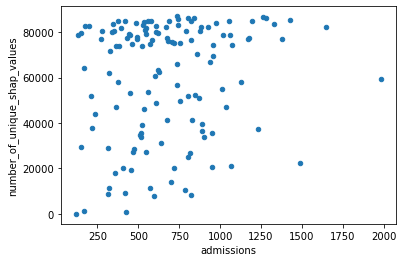

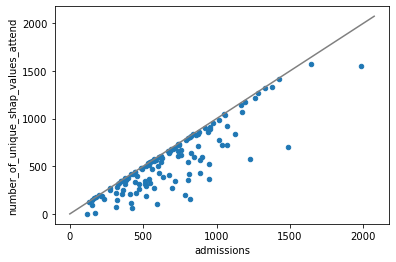

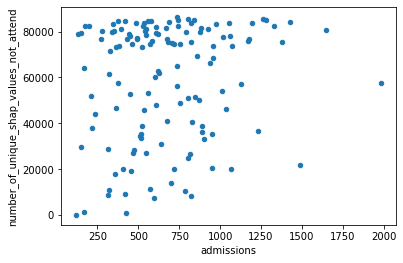

In [30]:
# Plot 1: Admissions vs number of unique SHAP values
#   All instances contributing to SHAP value count
df_hospital_details.plot.scatter(x="admissions", 
                                 y="number_of_unique_shap_values")

# Plot 2: Admissions vs number of unique SHAP values
#   Only instances that attend hosptial contributing to SHAP value count
ax = df_hospital_details.plot.scatter(x="admissions", 
                                      y="number_of_unique_shap_values_attend")
# Include x = y line (shows the max number of of unique values)
max_axis_value = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([0, max_axis_value], [0, max_axis_value], c='0.5')

# Plot 3: Admissions vs number of unique SHAP values
#   Only instances that do not attend hosptial contributing to SHAP value count
df_hospital_details.plot.scatter(x="admissions",
                                 y="number_of_unique_shap_values_not_attend")

Let's look at a hospital with the most unique values

In [31]:
row_index = df_hospital_details["number_of_unique_shap_values"].idxmax()
stroke_team_max_n_unique = df_hospital_details["Stroke team"].iloc[row_index]
print(f"Hospital {stroke_team_max_n_unique} has "
      f"{df_hospital_details['number_of_unique_shap_values'].max()} "
      f"unique values")

Hospital IAZKG9244A has 86995 unique values


Look at descriptive stats for this hospital

In [32]:
df_hosp_shap_main_effects[stroke_team_max_n_unique].describe()

count    88792.000000
mean        -0.000443
std          0.082385
min         -0.013439
25%         -0.008519
50%         -0.007911
75%         -0.007323
max          1.387742
Name: IAZKG9244A, dtype: float64

What's the difference between the SHAP main effect value for this hospital for the instances that attended it, compared to those instances that didn't?

Colour histogram bars to represent: Green for positive SHAP value, Grey for 0, and Red for negative SHAP value.

In [33]:
def create_histogram_with_colours(data, bins, ax):

    """
    data [DataFrame]: Single column of data containing values in the histogram
    bins [int]: Width of each histogram bar
    ax [object]: Matplotlib axes object
    
    Histogram bars are:
        green if positive value
        black if spans zero
        red if negative value
    
    Function return matplotlib axes object
    """
    
    N, bins, patches = ax.hist(data, edgecolor='white', linewidth=0.2, 
                               bins=bins);

    for i in range(N.shape[0]):
        if bins[i] < 0 and bins[i+1] < 0:
                patches[i].set_facecolor('red')
        elif bins[i] > 0 and bins[i+1] > 0:
                patches[i].set_facecolor('green')
        else:
            patches[i].set_facecolor('black')

    return(ax)

IAZKG9244A. Number of unique values for all patients (attended or not): 86995
Number of patients 88792
IAZKG9244A. Number of unique values for those patients who attended: 737
Number of patients 738
IAZKG9244A. Number of unique values for those patients who do not attended: 86258
Number of patients 88054


<function matplotlib.pyplot.show(close=None, block=None)>

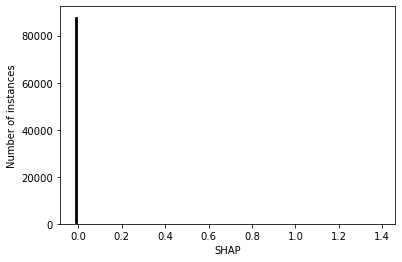

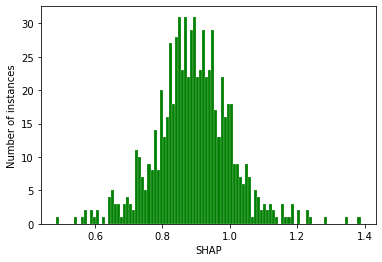

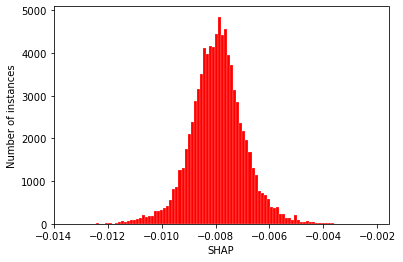

In [34]:
stroke_team = stroke_team_max_n_unique

mask1 = df_hosp_shap_main_effects["Stroke team"] == stroke_team
shap_values_attend = df_hosp_shap_main_effects[stroke_team][mask1]

mask2 = np.logical_not(mask1)
shap_values_not_attend = df_hosp_shap_main_effects[stroke_team][mask2]

# Plot histogram of SHAP main effect values for all instances
fig, ax = plt.subplots()
create_histogram_with_colours(df_hosp_shap_main_effects[stroke_team], 100, ax)
ax.set_xlabel(f"SHAP")
ax.set_ylabel("Number of instances")
print(f"{stroke_team}. Number of unique values for all patients (attended or "
      f"not): {df_hosp_shap_main_effects[stroke_team].nunique()}")
print(f"Number of patients {df_hosp_shap_main_effects[stroke_team].shape[0]}")
plt.show

# Plot histogram of SHAP main effect values for instances attend hospital
mask1 = mask1 * 1
s1 = mask1.sum()
fig, ax = plt.subplots()
ax = create_histogram_with_colours(shap_values_attend, 100, ax)
ax.set_xlabel(f"SHAP")
ax.set_ylabel("Number of instances")
print(f"{stroke_team}. Number of unique values for those patients who "
      f"attended: {shap_values_attend.nunique()}")
print(f"Number of patients {s1}")
plt.show

# Plot histogram of SHAP main effect values for instances not attend hospital
mask2 = mask2 * 1
s2 = mask2.sum()
fig, ax = plt.subplots()
ax = create_histogram_with_colours(shap_values_not_attend, 100, ax)
ax.set_xlabel(f"SHAP")
ax.set_ylabel("Number of instances")
print(f"{stroke_team}. Number of unique values for those patients who do not "
      f"attended: {shap_values_not_attend.nunique()}")
print(f"Number of patients {s2}")
plt.show


So there's two populations, but in the top plot you can not see the histogram for the instances that attended the hospital, as their frequency is too few and the plot is dominated by the frequency range for the number of patients who did not attend the hosptial.

Those that attend have a higher SHAP value, but there's fewer instances so can not see these values.
Those that do not attend have a low SHAP value, a smaller range of values, but far more instances, so dominates the y axis, but can not see the spread (as the other population has determines the x axis range).

Better to view as two populations.

Plot a boxplot for the SHAP values of each hospital (for all instances)

In [35]:
# Create list of values for each boxplot (one per hospital)
stroketeam_groups = []
for h in hospital_names:
    stroketeam_groups.append(df_hosp_shap_main_effects[h])

Shows the range of contributions to the prediction from this hospital for all the instances


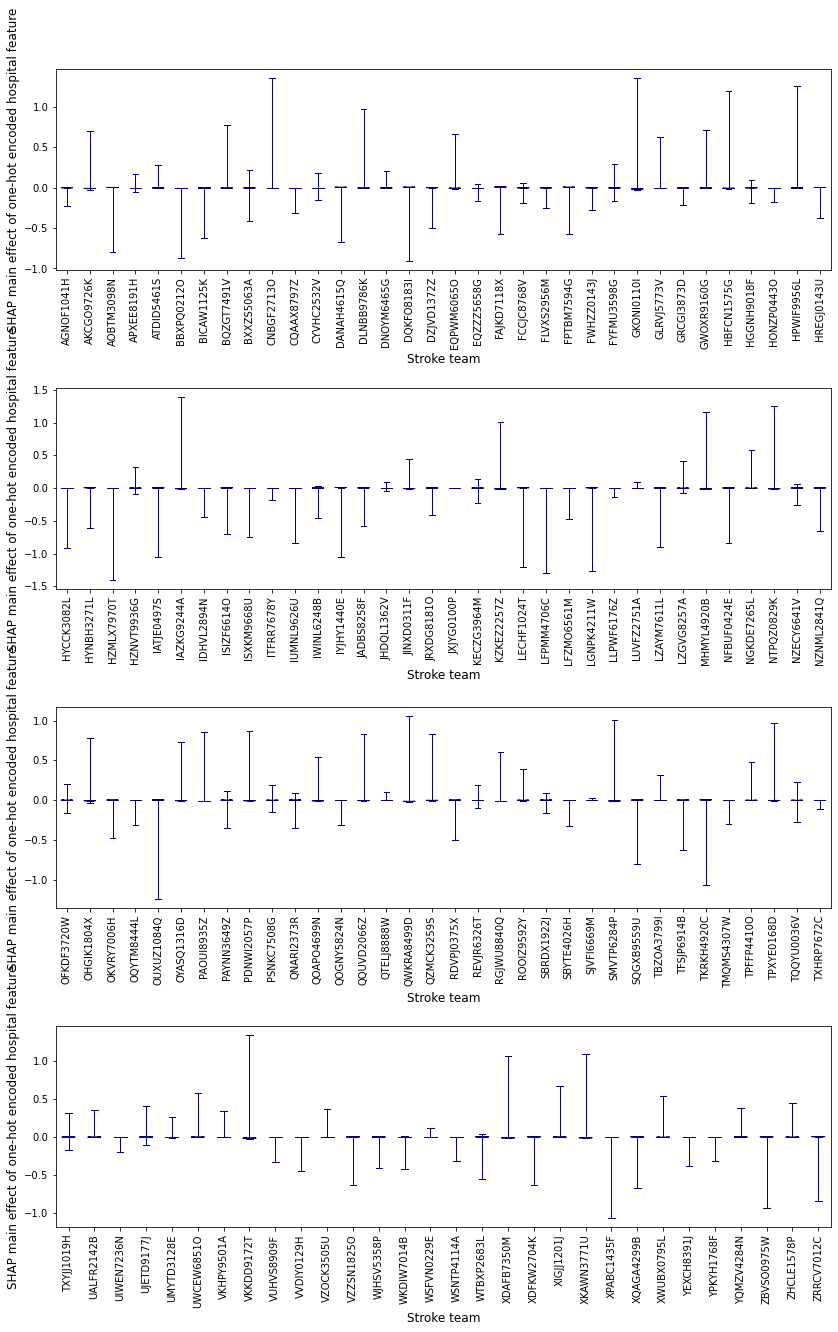

In [36]:
# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "for all the instances")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Plot properties
c1 = "navy"
c2 = "navy"
c3 = "white"

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,18))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)
    
    plt.boxplot(stroketeam_groups[st:ed],
                labels=df_hosp_shap_main_effects.columns[st:ed],
                whis=9999999, patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))
    plt.ylabel('SHAP main effect',size=12)
    plt.xlabel('Stroke team',size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)
plt.tight_layout(pad=2)
plt.show()

Shows that hospitals have the majority of their cases at value 0. Some hospitals have a wider range of SHAP main effect values than others, with most having their range entirely on one side of 0 or the other.

Let's plot it again, twice, showing only those instances that go to the hospital, and again when they do not.

Include instances that attend the hospital only

In [37]:
# Create list of values for each boxplot (one per hospital), only include SHAP 
#   value for instances that attend stroke team
attend_stroketeam_groups = []
for h in hospital_names:
    mask = df_hosp_shap_main_effects['Stroke team'] == h
    attend_stroketeam_groups.append(df_hosp_shap_main_effects[h][mask])

Shows the range of contributions to the prediction from this hospital when patients attend this hosptial


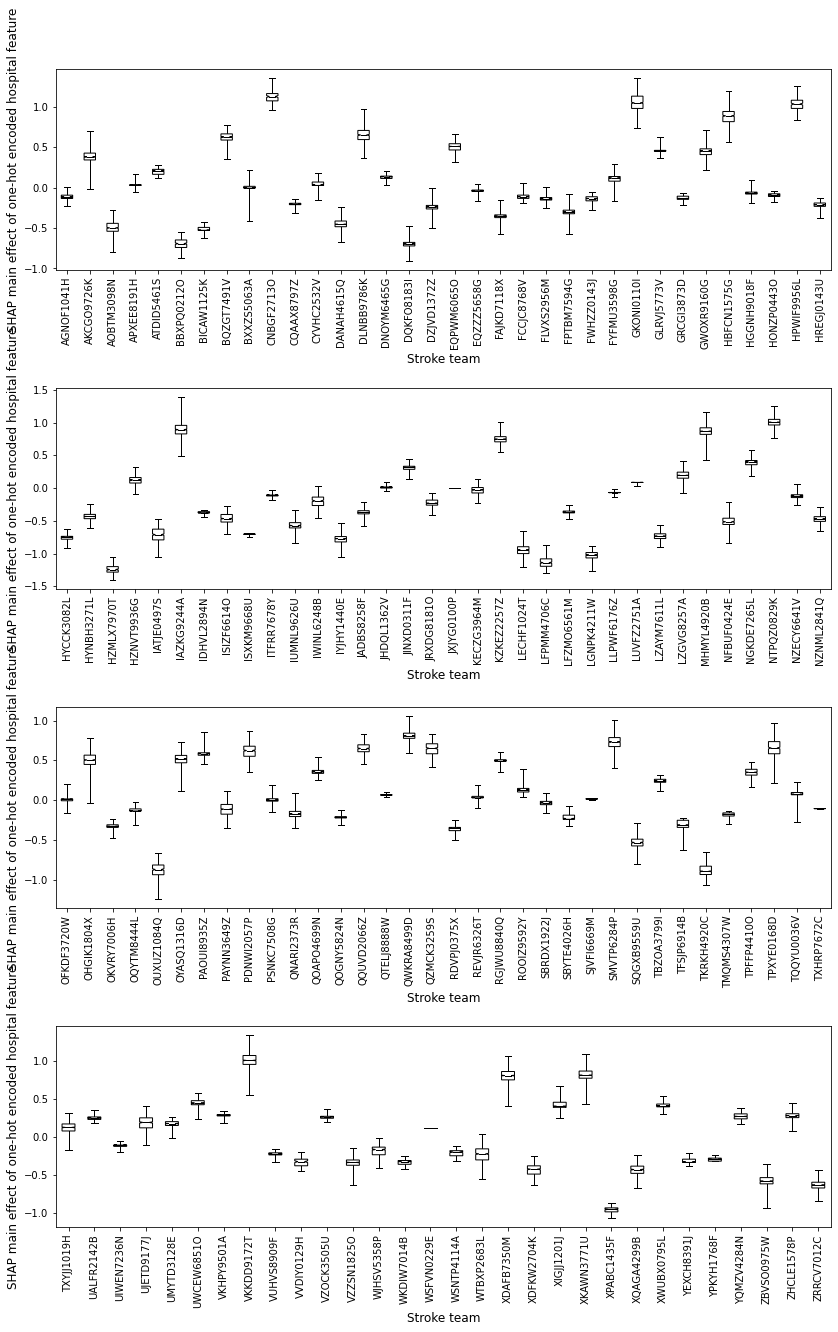

In [38]:
# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Plot properties
c1 = "black"
c2 = "black"
c3 = "white"

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,18))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)
    
    plt.boxplot(attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_main_effects.columns[st:ed],
                whis=999999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))

    plt.ylabel('SHAP main effect',size=12)
    plt.xlabel('Stroke team',size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

plt.subplots_adjust(bottom=0.25, wspace=0.05)    
plt.tight_layout(pad=2)
plt.show()

Edit data so only contains instances when not go to hospital

In [39]:
# Only include SHAP value for instances that do not attend stroke team
not_attend_stroketeam_groups = []
for h in hospital_names:
    mask = df_hosp_shap_main_effects['Stroke team'] != h
    not_attend_stroketeam_groups.append(df_hosp_shap_main_effects[h][mask])

Shows the range of contributions to the prediction from this hospital when patients do not attend this hosptial


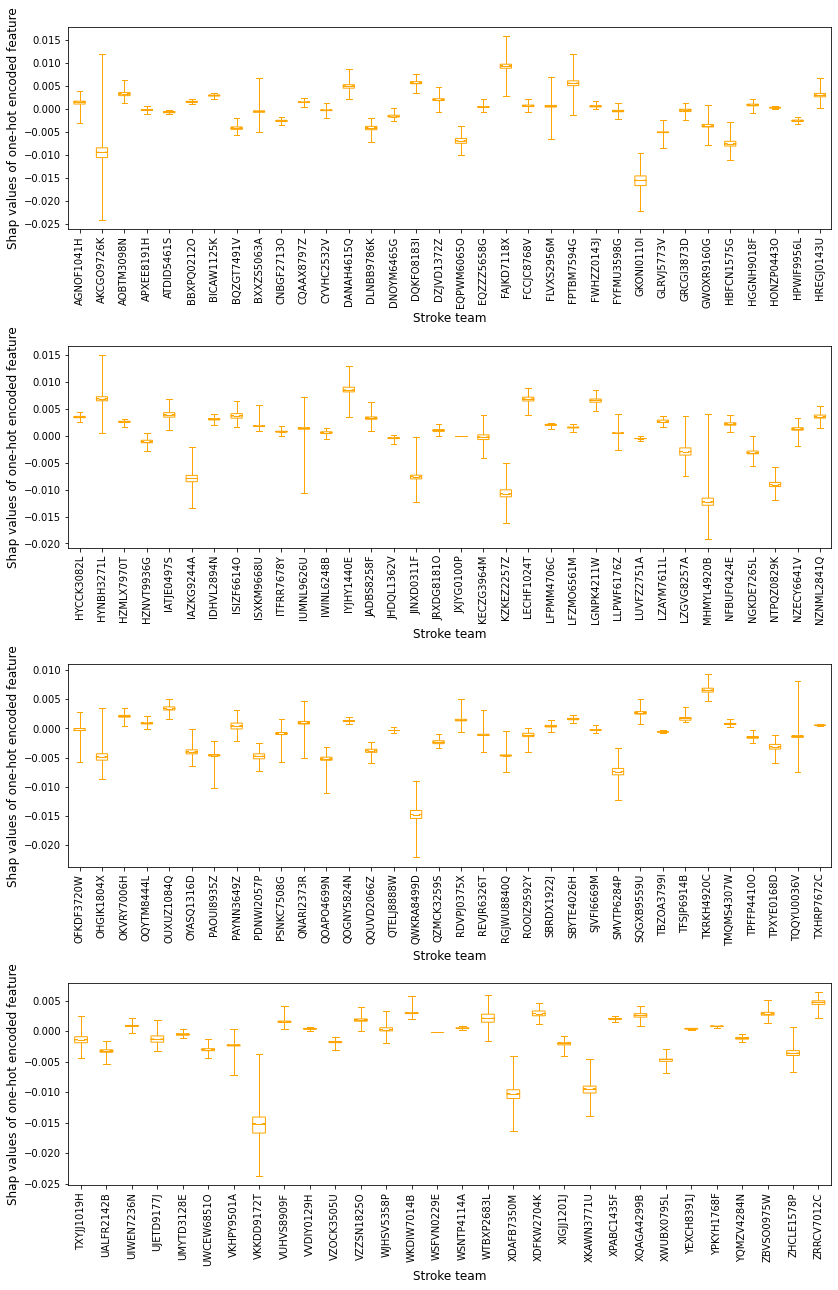

In [40]:
# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients do not attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Plot properties
c1 = "orange"
c2 = "orange"
c3 = "white"
 
# Create figure with 4 subplots
fig = plt.figure(figsize=(12,18))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)
    
    plt.boxplot(not_attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_main_effects.columns[st:ed],
                whis=999999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))
        
    plt.ylabel('Shap main effect', size=12)
    plt.xlabel('Stroke team', size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)
plt.tight_layout(pad=2)
plt.show()

Shows the range of contributions to the prediction from this hospital when patients 1) do [black], and 2) do not [orange] attend this hosptial


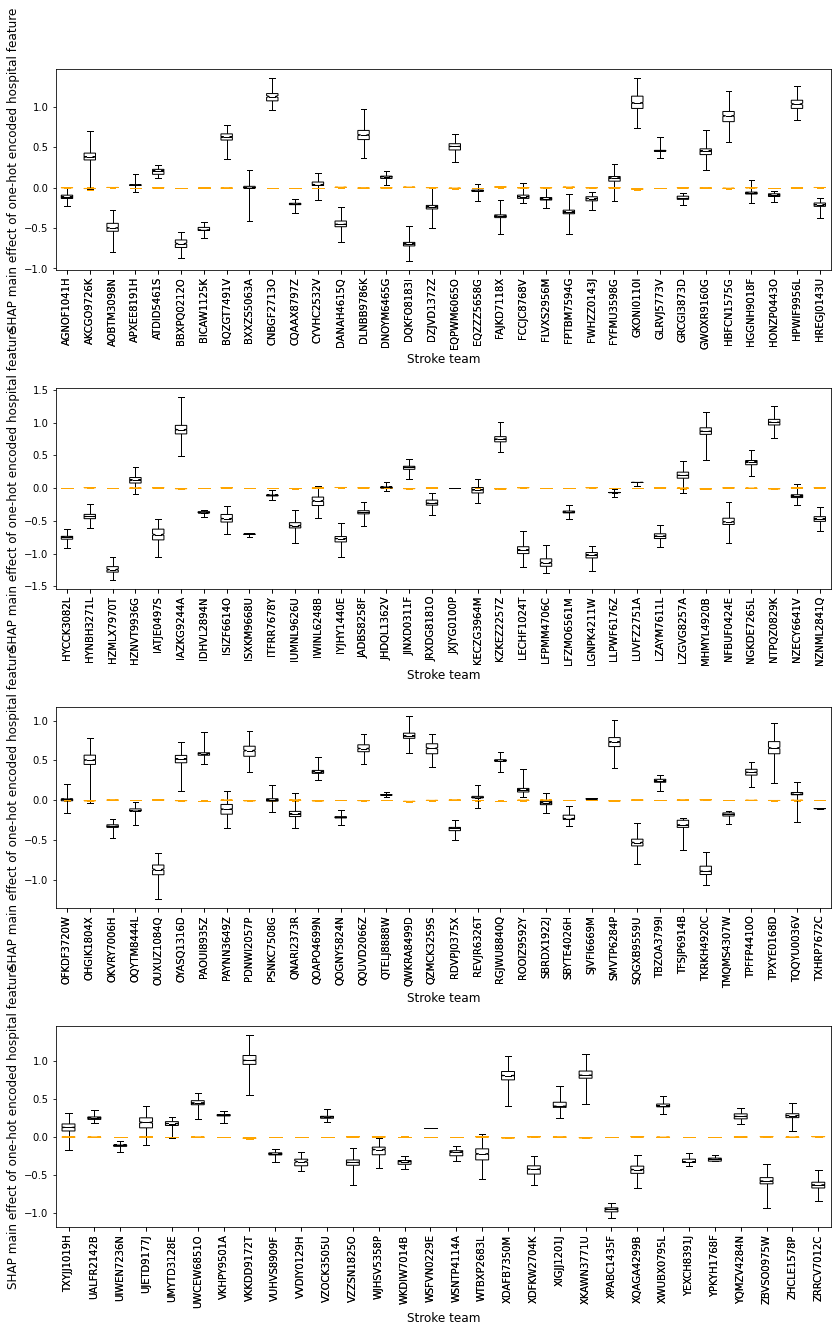

In [41]:
# Two box plots on 1 plot (spread of SHAP when instance attend, and not attend, hospital)

# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,18))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)
    
    # The contribution from this hospital when patients do not attend this hosptial
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    plt.boxplot(not_attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_main_effects.columns[st:ed],
                whis=99999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))
        
    # The contribution from this hospital when patients do attend this hosptial
    c1 = "black"
    c2 = "black"
    c3 = "white"
    plt.boxplot(attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_main_effects.columns[st:ed],
                whis=99999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))

    plt.ylabel('SHAP main effect',size=12)
    plt.xlabel('Stroke team',size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)
plt.tight_layout(pad=2)
plt.show()

Does it help understanding to represent this as histograms?

Create three matrix of histograms. 

* One with all the instances to each hosptial
* One with just the instances that attend each hosptial
* One with just the instances that don't attend each hosptial.

One with all the instances to each hosptial (forcing same axis ranges)

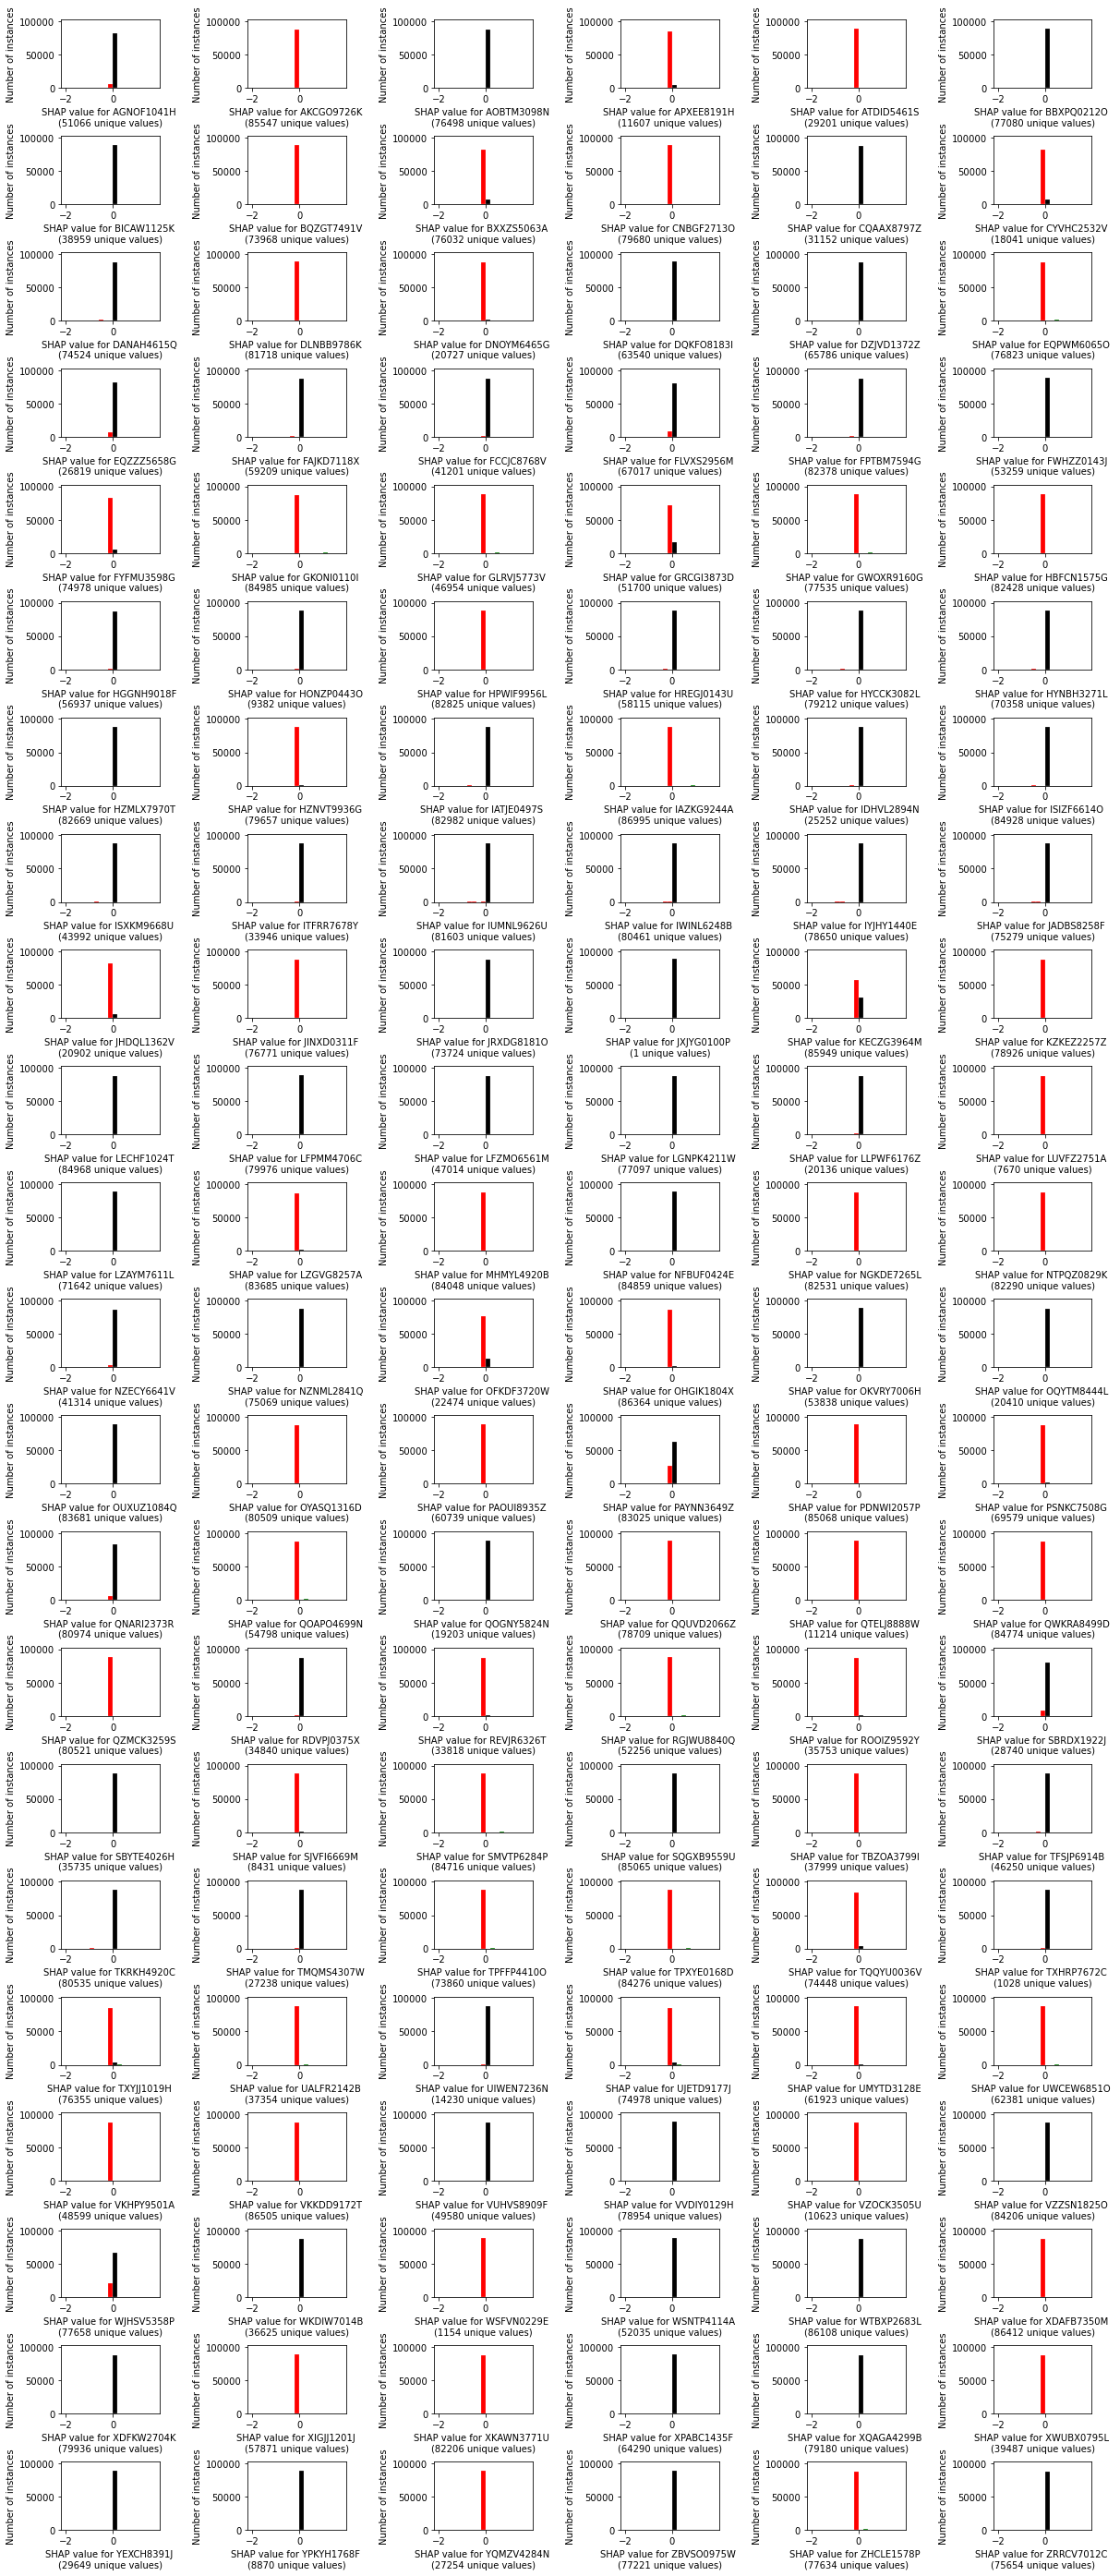

In [42]:
# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
x_min = 99
x_max = -99
fig, axes = plt.subplots(1)
for h in hospital_names:
    # Plot histogram
    axes.hist(df_hosp_shap_main_effects[h])
    # Get axis limits
    ylims = axes.get_ylim()
    # Store if greater than found so far
    y_max = max(y_max, ylims[1])
    # Get axis limits
    xlims = axes.get_xlim()
    # Store if greater than found so far
    x_min = min(x_min, xlims[0])
    x_max = max(x_max, xlims[1])
# Don't display plot
plt.close(fig)

# Define width of histogram bins based on the x axis range
bin_width = (abs(math.floor(xlims[0])) + abs(math.ceil(xlims[1])))/20

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    n_unique = df_hosp_shap_main_effects[h].nunique()
    ax=axes[count]
    create_histogram_with_colours(df_hosp_shap_main_effects[h],
            np.arange(math.floor(xlims[0]),math.ceil(xlims[1]),bin_width),
            ax)
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances")
    ax.set_ylim(0, (y_max*1.1))
    count += 1

# Define figure display
fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

One with just the instances that attend each hosptial

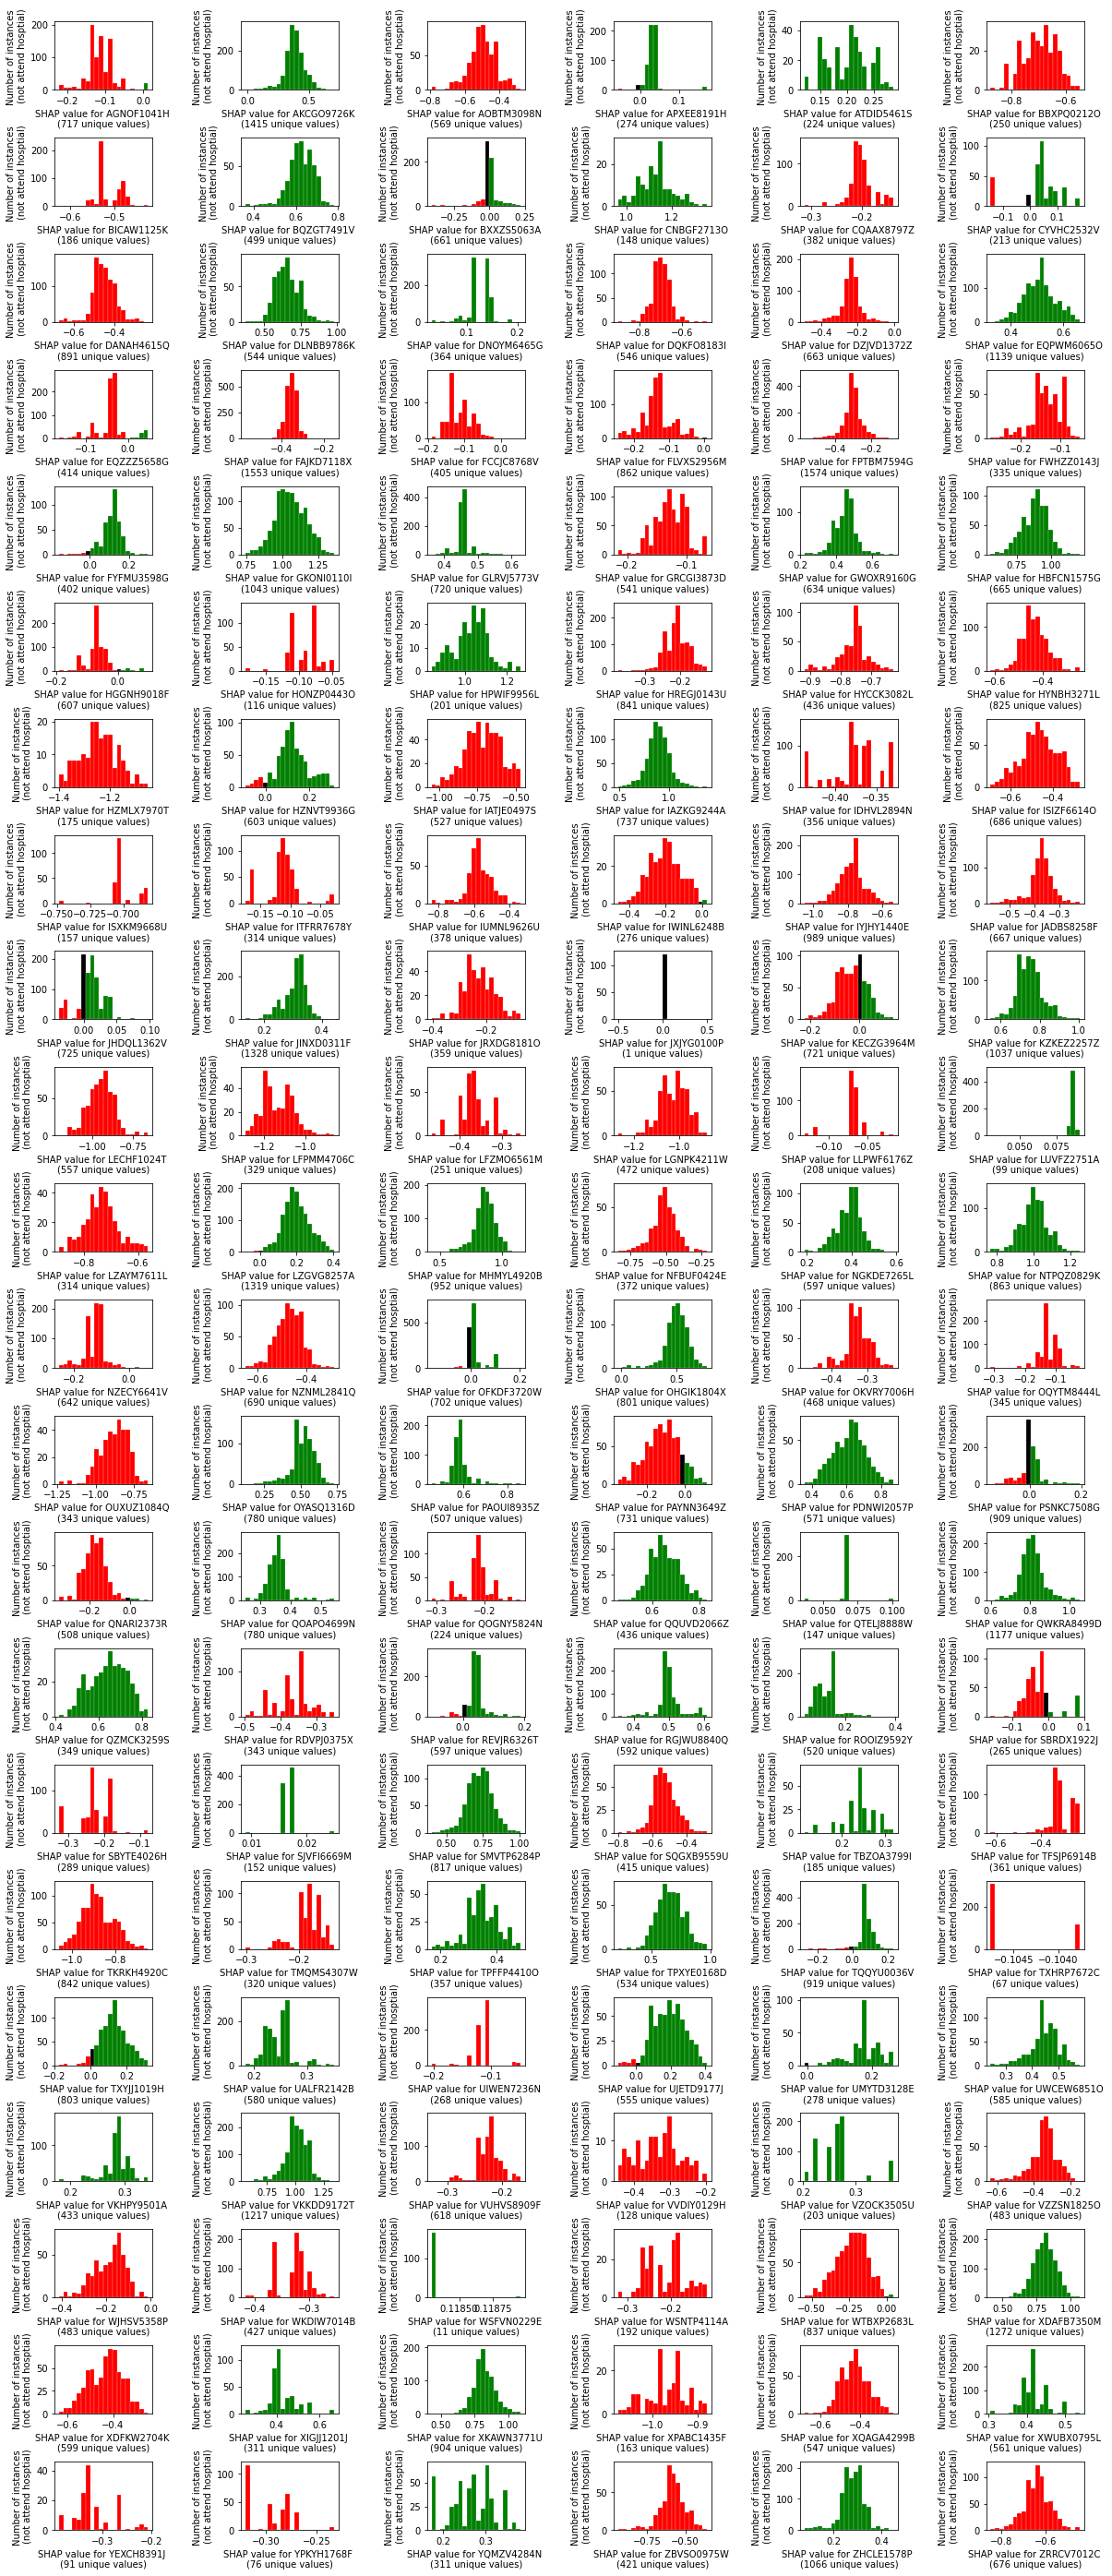

In [43]:
# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    mask = X_combined["Stroke team"] == h #drop "team_"
    shap_values_not_attend = df_hosp_shap_main_effects[h][mask]
    n_unique = shap_values_not_attend.nunique()
    ax=axes[count]
    create_histogram_with_colours(shap_values_not_attend, 20, ax)
#    ax.hist(shap_values_not_attend, bins=20)
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances \n(not attend hosptial)")
#    ax.set_ylim(0, y_max)
#    ax.set_xlim(x_min, x_max)
    count += 1

fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

One with just the instances that don't attend each hosptial.

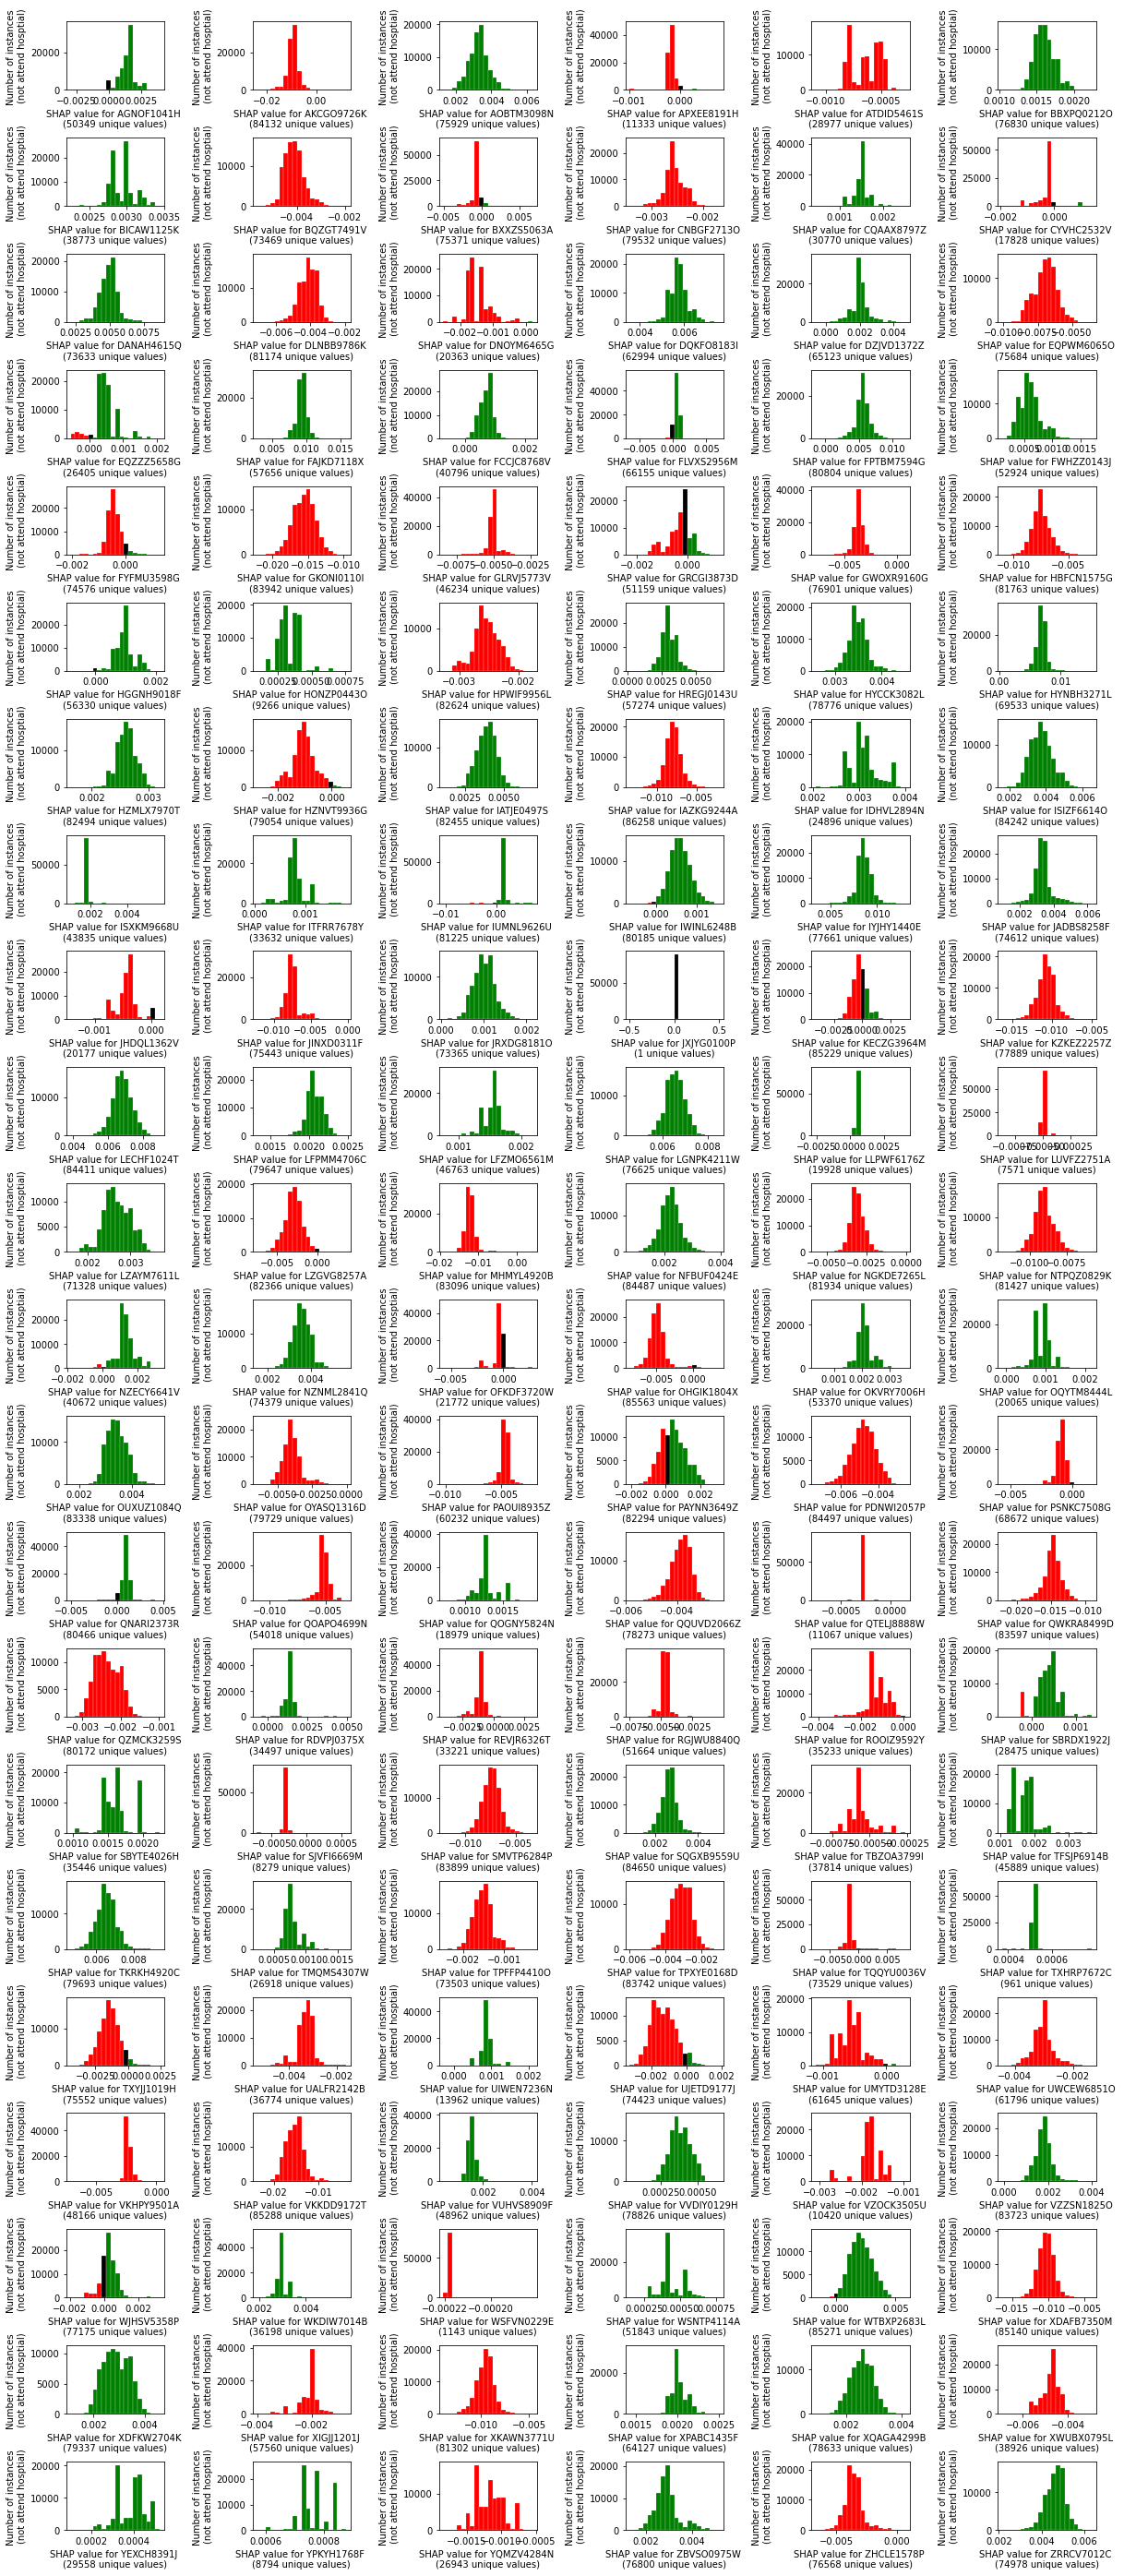

In [44]:
# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    mask = X_combined["Stroke team"] == h #drop "team_"
    mask = np.logical_not(mask)# Those that didn't attend
    shap_values_not_attend = df_hosp_shap_main_effects[h][mask]
    n_unique = shap_values_not_attend.nunique()
    ax=axes[count]
    create_histogram_with_colours(shap_values_not_attend, 20, ax)
#    ax.hist(shap_values_not_attend, bins=20)
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances \n(not attend hosptial)")
#    ax.set_ylim(0, y_max)
#    ax.set_xlim(x_min, x_max)
    count += 1

fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

Code showing the same histograms, with each having the same x axis range and y axis range

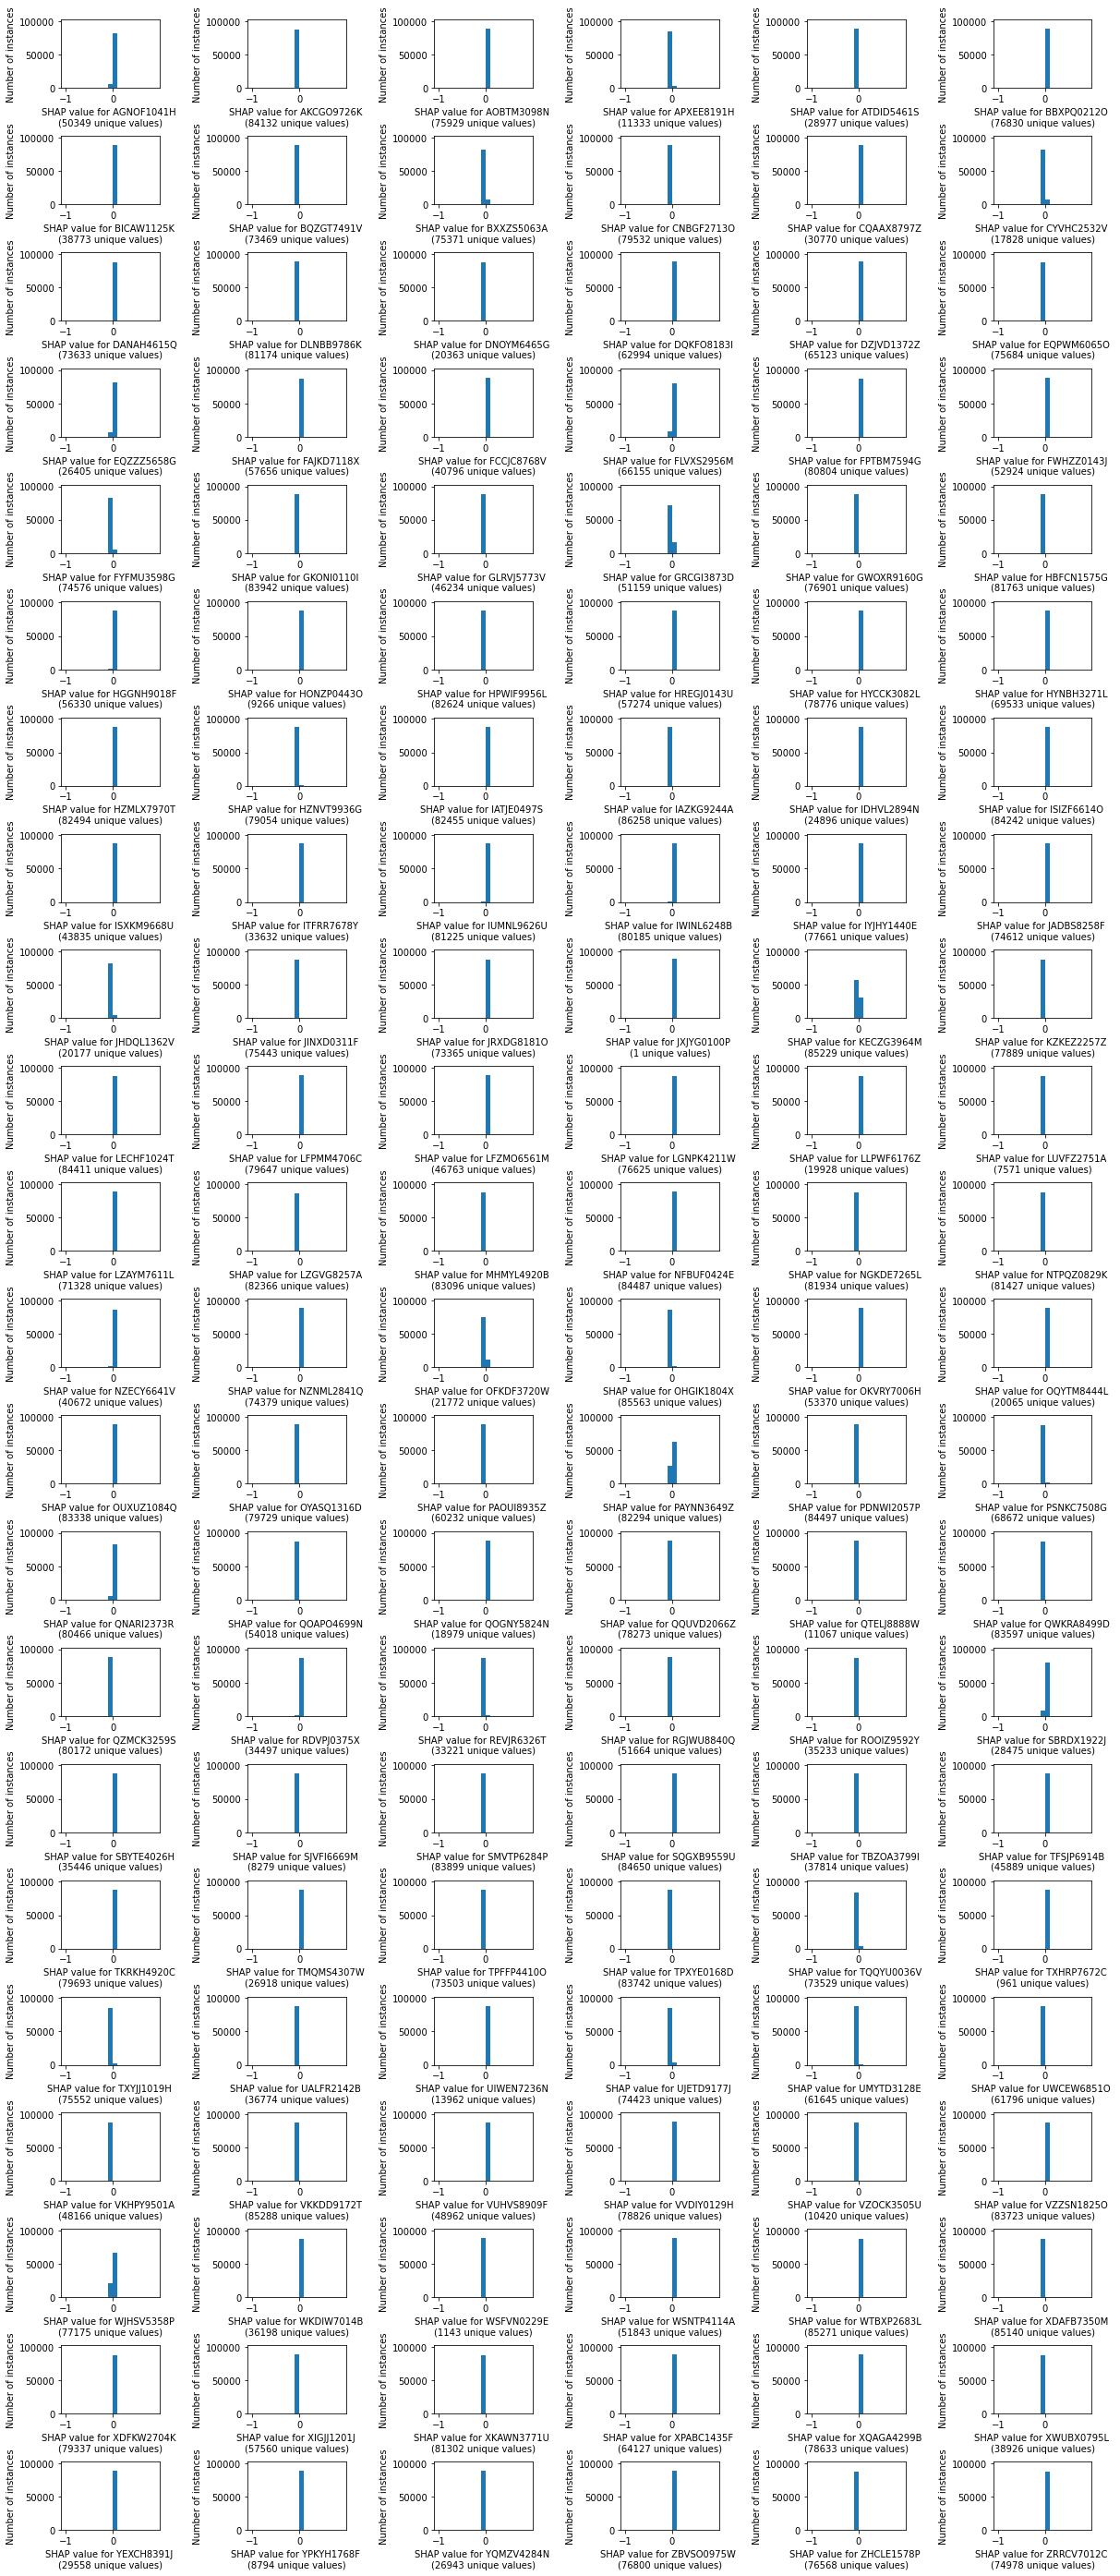

In [45]:
# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
x_min = 99
x_max = -99
fig, axes = plt.subplots(1)
for h in hospital_names:
    # mask data for those that attend hospital
    mask = df_hosp_shap_main_effects["Stroke team"] == h
    # Those that didn't attend
    mask = np.logical_not(mask)
    shap_values_attend = df_hosp_shap_main_effects[h][mask]
    n_unique = shap_values_attend.nunique()
    # Plot histogram
    axes.hist(shap_values_attend)
    # Get axis limits
    ylims = axes.get_ylim()
    # Store if greater than found so far
    y_max = max(y_max, ylims[1])
    # Get axis limits
    xlims = axes.get_xlim()
    # Store if greater than found so far
    x_min = min(x_min, xlims[0])
    x_max = max(x_max, xlims[1])
# Don't display plot
plt.close(fig)

# Define width of histogram bins based on the x axis range
bin_width = (abs(math.floor(xlims[0])) + abs(math.ceil(xlims[1])))/20

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    # mask data for those that attend hospital
    mask = df_hosp_shap_main_effects["Stroke team"] == h
    # Those that didn't attend
    mask = np.logical_not(mask)
    shap_values_attend = df_hosp_shap_main_effects[h][mask]
    n_unique = shap_values_attend.nunique()
    # Plot histogram
    ax=axes[count]
    ax.hist(shap_values_attend, 
            bins=np.arange(math.floor(xlims[0]),math.ceil(xlims[1]),bin_width))
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances")
    ax.set_ylim(0, (y_max*1.1))
    count += 1

# Define figure display
fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()